PCA

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [6]:
# data folder to cleaned csv
path = '/content/drive/MyDrive/fall2025/csci5526/CSCI 5526 Project/clean_dataset.csv' # Kenna

In [55]:
# load and prep data
df = pd.read_csv(path)
print("Original shape:", df.shape)

#converting the time columns to real datetimes (needed for ICU readmission label)
for col in ["ADMITTIME", "DISCHTIME", "INTIME", "OUTTIME"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")


#for different models:
#a) 30-day readmission-- READMIT_30D already computed in prep.ipynb
#b) Mortality
#use HOSPITAL_EXPIRE_FLAG (0 = survived, 1 = died in hospital)
if "HOSPITAL_EXPIRE_FLAG" in df.columns:
    df["HOSPITAL_EXPIRE_FLAG"] = df["HOSPITAL_EXPIRE_FLAG"].fillna(0).astype(int)
#c) ICU readmission within 30 days
#next ICU admission for the same SUBJECT_ID starting within 30 days (720 hours) after current ICU OUTTIME.
if {"SUBJECT_ID", "INTIME", "OUTTIME"}.issubset(df.columns):
    df = df.sort_values(["SUBJECT_ID", "INTIME"])
    df["NEXT_ICU_INTIME"] = df.groupby("SUBJECT_ID")["INTIME"].shift(-1)

    df["HOURS_TO_NEXT_ICU"] = (
        (df["NEXT_ICU_INTIME"] - df["OUTTIME"]).dt.total_seconds() / 3600
    )

    df["ICU_READMIT_30D"] = (df["HOURS_TO_NEXT_ICU"] <= 720).astype(float)
    df["ICU_READMIT_30D"] = df["ICU_READMIT_30D"].fillna(0).astype(int)
else:
    print("Warning: cannot create ICU_READMIT_30D (missing SUBJECT_ID/INTIME/OUTTIME).")


#dropping columns
cols_to_drop = [
    # unneeded identifiers
    "ROW_ID_x", "ROW_ID_y", "ROW_ID",
    "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID",

    # unused time columns (we already used them for labels)
    "ADMITTIME", "DISCHTIME", "DEATHTIME",
    "EDREGTIME", "EDOUTTIME", "INTIME", "OUTTIME",
    "DOB", "DOD", "DOD_HOSP", "DOD_SSN",

    # label construction helpers (would leak information)
    "NEXT_ADMITTIME", "HOURS_TO_NEXT",
    "NEXT_ICU_INTIME", "HOURS_TO_NEXT_ICU",

    # extra mortality-related flag that can leak label info
    "EXPIRE_FLAG",
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("After dropping ID / time / helper cols:", df.shape)

#dropping columns with >80% NaN
nan_threshold = 0.8
df = df.dropna(axis=1, thresh=len(df) * (1 - nan_threshold))
print("After dropping mostly-NaN columns:", df.shape)

#make sure our three targets still exist
label_cols = ["READMIT_30D", "HOSPITAL_EXPIRE_FLAG", "ICU_READMIT_30D"]
label_cols = [c for c in label_cols if c in df.columns]
print("Available targets:", label_cols)

Original shape: (62722, 101)
After dropping ID / time / helper cols: (62722, 82)
After dropping mostly-NaN columns: (62722, 82)
Available targets: ['READMIT_30D', 'HOSPITAL_EXPIRE_FLAG', 'ICU_READMIT_30D']


In [56]:
df.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,...,mean_51265,mean_51300,min_50912,min_50971,min_50983,min_51006,min_51222,min_51265,min_51300,ICU_READMIT_30D
0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NEWBORN,0,...,153.50,6.25,0.9,4.0,138.0,18.0,0.0,5.0,6.25,0
1,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,HYPOTENSION,0,...,255.25,6.25,2.4,3.9,138.0,41.0,7.8,190.0,6.25,0
2,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,...,201.00,6.25,0.5,3.3,141.0,10.0,10.6,201.0,6.25,0
3,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NEWBORN,0,...,309.00,6.25,0.9,4.0,138.0,18.0,14.9,309.0,6.25,0
4,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHRONIC RENAL FAILURE/SDA,0,...,322.50,6.25,10.0,4.8,134.0,62.0,9.2,315.0,6.25,0


In [57]:
import re

# function to convert ids to feature names
# Vital item IDs (MIMIC-III standard)
VITALS = {
    "HR": [220045],
    "SysBP": [220179, 51],
    "DiasBP": [220180, 8368],
    "MeanBP": [220181],
    "RR": [220210],
    "SpO2": [220277],
    "TempC": [223761, 678],
}

# Lab item IDs
LABS = {
    "WBC": [51300],
    "HGB": [51222],
    "Platelets": [51265],
    "Sodium": [50983],
    "Potassium": [50971],
    "Creatinine": [50912],
    "BUN": [51006],
}

def convert_ids_to_feature_names(df, VITALS, LABS):
  '''convert column IDs back to feature names
  used for feature importance'''
  id_dict = VITALS | LABS
  mapper = {}
  cols = df.columns

  # Create a list of (id_string, key) pairs for replacement
  # Prioritize longer ID strings to avoid partial matches if ID is short
  replacements_list = []
  for key, id_values in id_dict.items():
      for id_val in id_values:
          replacements_list.append((str(id_val), key))

  # Sort by length of ID string in descending order
  replacements_list.sort(key=lambda x: len(x[0]), reverse=True)

  for col in cols:
    new_col = col
    replaced = False
    for old_id_str, new_key_name in replacements_list:
        # Construct a regex pattern to match the ID as a distinct number at the end of a string segment.
        match = re.search(r'(_)?' + re.escape(old_id_str) + r'$', new_col)
        if match:
            # Replace matched ID with the new key name.
            prefix_underscore = match.group(1) if match.group(1) else ''
            new_col = new_col[:match.start()] + prefix_underscore + new_key_name
            replaced = True
            break

    mapper[col] = new_col
  df_new  = df.rename(columns=mapper)
  return mapper, df_new

In [58]:
# convert column names
df_coded = df.copy()
mapper, df = convert_ids_to_feature_names(df, VITALS, LABS)
df.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,...,mean_Platelets,mean_WBC,min_Creatinine,min_Potassium,min_Sodium,min_BUN,min_HGB,min_Platelets,min_WBC,ICU_READMIT_30D
0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NEWBORN,0,...,153.50,6.25,0.9,4.0,138.0,18.0,0.0,5.0,6.25,0
1,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,HYPOTENSION,0,...,255.25,6.25,2.4,3.9,138.0,41.0,7.8,190.0,6.25,0
2,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,...,201.00,6.25,0.5,3.3,141.0,10.0,10.6,201.0,6.25,0
3,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NEWBORN,0,...,309.00,6.25,0.9,4.0,138.0,18.0,14.9,309.0,6.25,0
4,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHRONIC RENAL FAILURE/SDA,0,...,322.50,6.25,10.0,4.8,134.0,62.0,9.2,315.0,6.25,0


In [ ]:
!pip install prince
!pip install light_famd

In [59]:
# FAMD (optional if enough RAM)

# prince automatically scales data
# PROBLEM: FAMD requires to much RAM
# FAMD: https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210/
# and https://nextjournal.com/pc-methods/calculate-pc-mixed-data
# and https://en.wikipedia.org/wiki/Factor_analysis_of_mixed_data
# and https://maxhalford.github.io/prince/famd/
#import prince
#from light_famd import FAMD

# setup data
#don't allow any of the label (target) columns to be features
labels_present = [c for c in label_cols if c in df.columns]
feature_df = df.drop(columns=labels_present)
numerical_only = feature_df.select_dtypes(include=[np.number])

y = df[label_cols]
X = feature_df

famd_binary = False
if famd_binary:
  #apply prince
  famd = prince.FAMD(
      n_components=2,
      n_iter=3,
      copy=False,
      check_input=True,
      engine='auto',
      random_state=42
      )
  famd = famd.fit(X)
  famd.eigenvalues_summary

In [60]:
# PCA of numerical features only
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features (numerical features only)
X = numerical_only
scaler = StandardScaler()
scaled = scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=10)
X_projected = pca.fit_transform(scaled)

In [61]:
print('Explained Variance:')
print(pca.explained_variance_ratio_)

Explained Variance:
[0.09590237 0.0571818  0.05352844 0.04649763 0.04481163 0.04256649
 0.04180047 0.03840926 0.03407121 0.03064077]


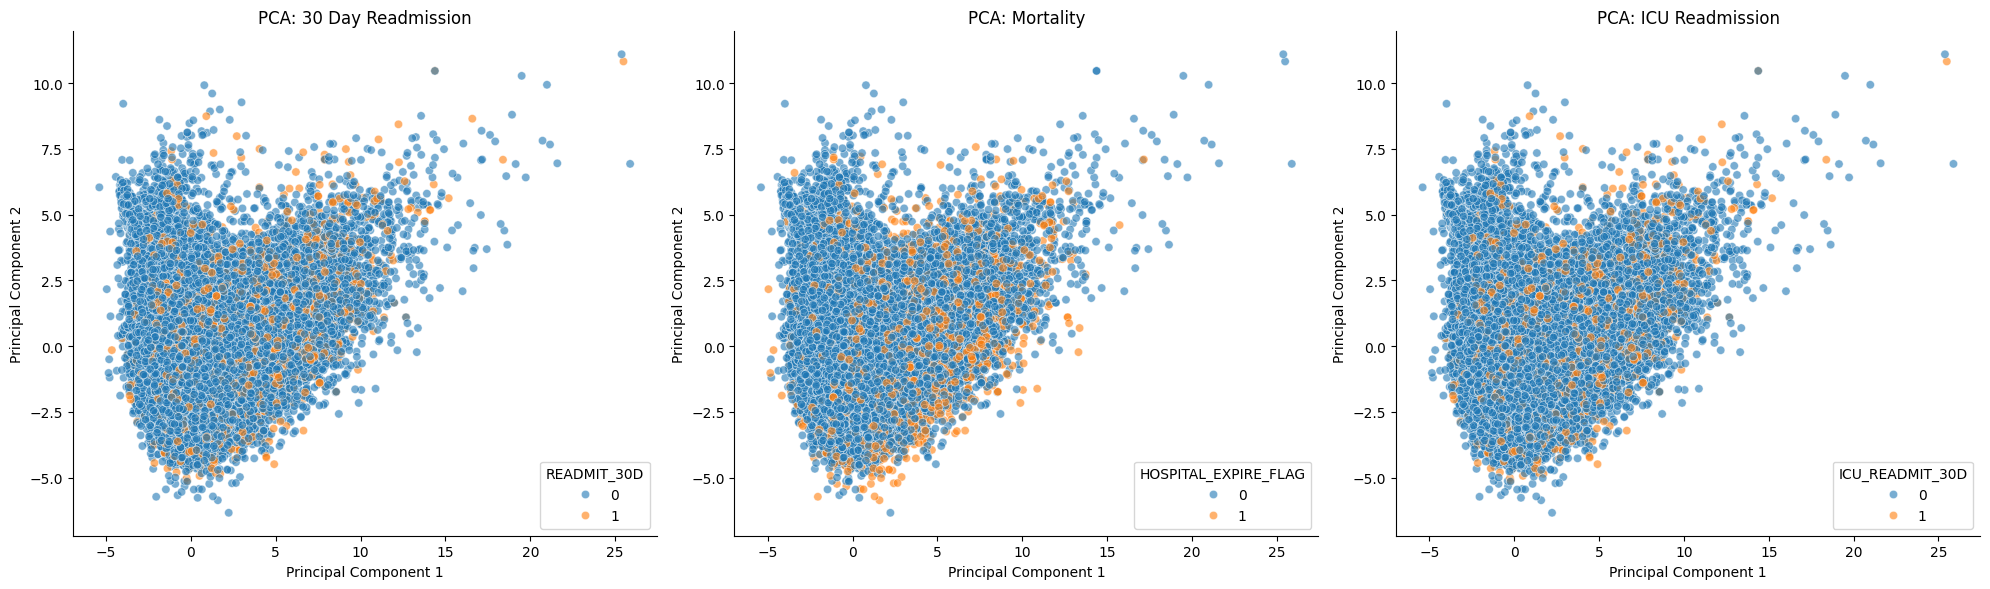

In [62]:
# plot

# 2D scatter plot
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.scatterplot(x=X_projected[:, 0], y=X_projected[:,1], hue=y['READMIT_30D'], alpha=0.6)
sns.despine()
plt.title('PCA: 30 Day Readmission')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()

plt.subplot(1,3,2)
sns.scatterplot(x=X_projected[:, 0], y=X_projected[:,1], hue=y['HOSPITAL_EXPIRE_FLAG'], alpha=0.6)
sns.despine()
plt.title('PCA: Mortality')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()

plt.subplot(1,3,3)
sns.scatterplot(x=X_projected[:, 0], y=X_projected[:,1], hue=y['ICU_READMIT_30D'], alpha=0.6)
sns.despine()
plt.title('PCA: ICU Readmission')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

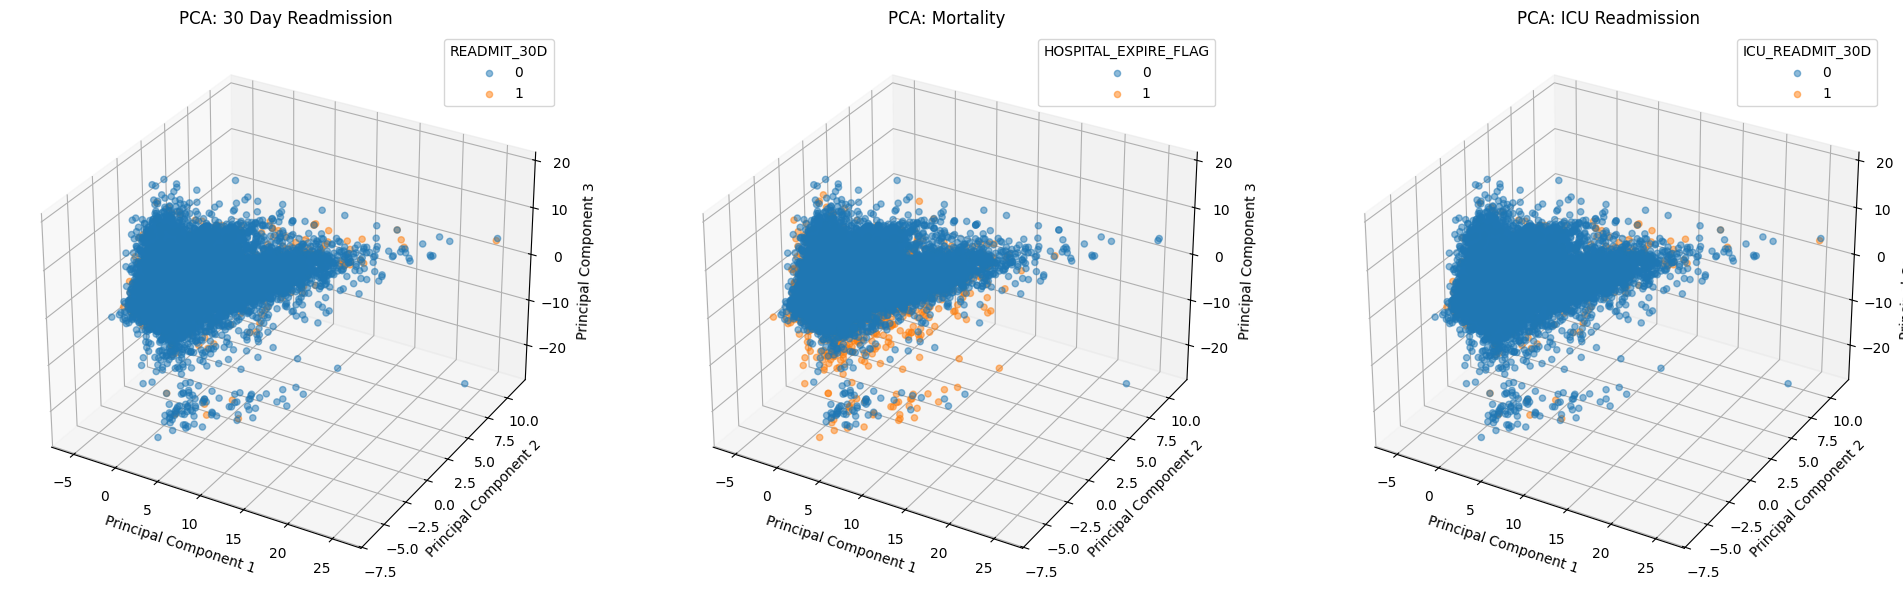

In [50]:
# plot
# 3D scatter plot
plt.figure(figsize=(20,6))

# hospital readmission
ax = plt.subplot(1,3,1, projection='3d')
for val in sorted(y['READMIT_30D'].unique()):
    ax.scatter(X_projected[y['READMIT_30D'] == val, 0],
               X_projected[y['READMIT_30D'] == val, 1],
               X_projected[y['READMIT_30D'] == val, 2],
               label=f'{val}', alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA: 30 Day Readmission')
ax.legend(title='READMIT_30D')
# rotation
#elev = 30
#azim = -45
#roll = 0
#ax.view_init(elev, azim, roll)
ax.spines[['top', 'right']].set_visible(False)

ax = plt.subplot(1,3,2, projection='3d')
for val in sorted(y['HOSPITAL_EXPIRE_FLAG'].unique()):
    ax.scatter(X_projected[y['HOSPITAL_EXPIRE_FLAG'] == val, 0],
               X_projected[y['HOSPITAL_EXPIRE_FLAG'] == val, 1],
               X_projected[y['HOSPITAL_EXPIRE_FLAG'] == val, 2],
               label=f'{val}', alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA: Mortality')
ax.legend(title='HOSPITAL_EXPIRE_FLAG')
ax.spines[['top', 'right']].set_visible(False)

ax = plt.subplot(1,3,3, projection='3d')
for val in sorted(y['ICU_READMIT_30D'].unique()):
    ax.scatter(X_projected[y['ICU_READMIT_30D'] == val, 0],
               X_projected[y['ICU_READMIT_30D'] == val, 1],
               X_projected[y['ICU_READMIT_30D'] == val, 2],
               label=f'{val}', alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA: ICU Readmission')
ax.legend(title='ICU_READMIT_30D')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

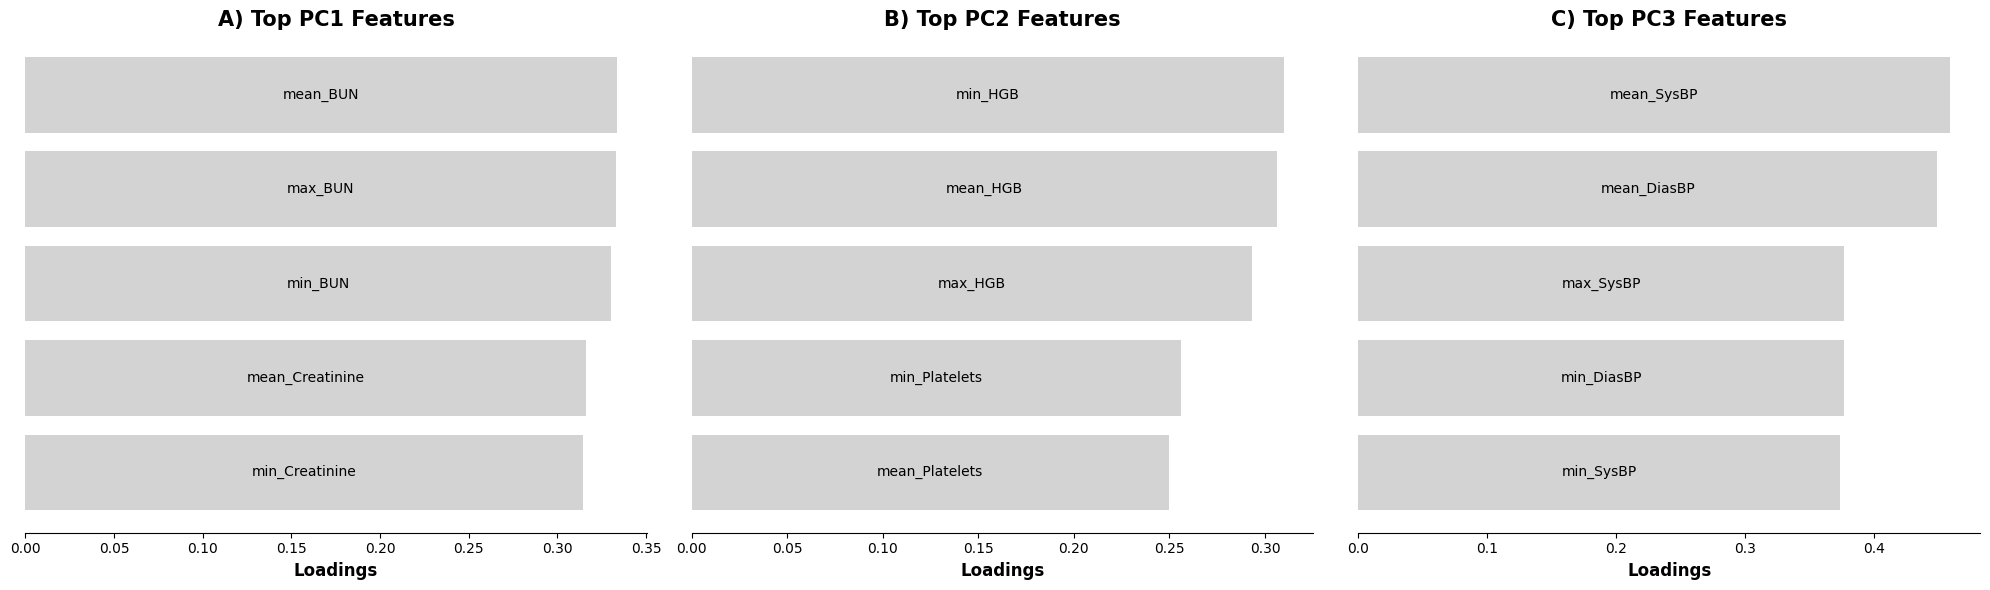

In [66]:
# PC1 loadings
# initialize plot
fig, ax = plt.subplot_mosaic([['A', 'B', 'C']], figsize=(20, 6))
ax1 = fig.add_subplot(ax['A'])
ax1.set_title('A) Top PC1 Features', weight='bold', size=15)
ax1.spines[['top', 'left', 'right']].set_visible(False)
ax1.set_xlabel('Loadings', weight='bold', size=12)
ax1.set_yticks([])
ax1.set_ylabel("")

# get top 5 loadings of PCA1
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
                        index=X.columns)
loadings.sort_values('PC1', ascending=False, inplace=True)

# plot
bars = ax1.barh(loadings.index[:5], width=loadings['PC1'][:5], color='lightgray')
ax1.bar_label(bars, label_type='center', color='black', labels=loadings.index[:5])
ax1.invert_yaxis()

# plot PC2
ax2 = fig.add_subplot(ax['B'])
ax2.set_title('B) Top PC2 Features', weight='bold', size=15)
ax2.spines[['top', 'left', 'right']].set_visible(False)
ax2.set_xlabel('Loadings', weight='bold', size=12)
ax2.set_yticks([])
ax2.set_ylabel("")
loadings.sort_values('PC2', ascending=False, inplace=True)
bars = ax2.barh(loadings.index[:5], width=loadings['PC2'][:5], color='lightgray')
ax2.bar_label(bars, label_type='center', color='black', labels=loadings.index[:5])
ax2.invert_yaxis()

# plot PC3
ax3 = fig.add_subplot(ax['C'])
ax3.set_title('C) Top PC3 Features', weight='bold', size=15)
ax3.spines[['top', 'left', 'right']].set_visible(False)
ax3.set_xlabel('Loadings', weight='bold', size=12)
ax3.set_yticks([])
ax3.set_ylabel("")
loadings.sort_values('PC3', ascending=False, inplace=True)
bars = ax3.barh(loadings.index[:5], width=loadings['PC3'][:5], color='lightgray')
ax3.bar_label(bars, label_type='center', color='black', labels=loadings.index[:5])
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

In [69]:
X.shape

(62722, 66)